In [1]:
subj = 'UI399'
root_dir = '/Users/alia/Documents/mandarin'

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from os.path import join, exists
from os import makedirs
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fftpack
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from numpy import linalg as LA
from sklearn.preprocessing import scale
import random
import librosa
from scipy import stats

import plotly
plotly.tools.set_credentials_file(username='ashafi', api_key='PxONlbVA45fzeK3YWWb9')
from plotly.offline import iplot, init_notebook_mode
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import peakutils
import plotly.graph_objs as go


/Users/alia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Create directories
fdir = root_dir + '/mandarin_ffr/fig/' + subj
odir = root_dir + '/output/' + subj

if not exists(fdir):
    makedirs(fdir)
if not exists(odir):
    makedirs(odir)

In [4]:
# Where are the data?
dir_data = ''.join([root_dir, '/', subj, '/data'])
file_ECoG = ''.join([dir_data, '/', subj, '_dat_clicks_block_8.mat'])
# file_ECoG = ''.join([dir_data, '/', subj, '_dat_FFR.mat'])

# Load the .mat file
f = h5py.File(file_ECoG, 'r')

# Read ECoG data
hg_stim = np.array(f['dat']['lfp']) # trial * tp * ch
time_axis = (np.round(f['dat']['time_axis'].value.flatten(), 3) * 1000).astype(int) # Use int b/c float precision



# Import behav
behav = np.array(f['dat']['behav'])
    
f.close()



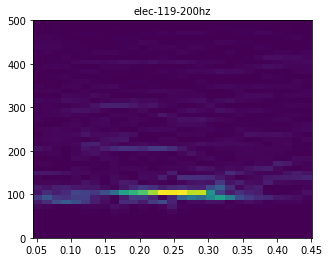

In [21]:
## plot elecs 
plt.figure(figsize = (5,4))
myidx = np.where(behav[1]==100)
myhg = np.mean(hg_stim[myidx[0], :, 119], axis = 0)
# plt.plot(myhg)
f,t, Sxx = signal.spectrogram(myhg[400:900], 1000, noverlap = 76, nperseg =90)
plt.pcolormesh(t,f,Sxx, vmax = np.percentile(Sxx.flatten(), 99.9))
plt.title("elec-" + str(119)+ "-200hz", fontsize = 10)
# plt.axvline(x=500,color = 'r')
# plt.axvline(x=534, color = 'r')
plt.show()

In [ ]:
myhg = np.mean(hg_stim[:, :, 119], axis = 0)

In [181]:
myhg = np.mean(hg_stim[:, :, 0], axis = 0)

In [5]:
def get_RMS(trial,e):
    '''taks in trial and electrode and finds the RMS within a 100 ms pre and post stim onset'''
    mymean = hg_stim[trial, :, e]

    #calculates the square for the mean of the data set to get all values to be positive
    RMS_mymean = np.square(mymean)

    #get prestim and after stim means
    prestim = mymean[np.where((time_axis <= 0) & (time_axis >= -100))[0]]
    poststim = mymean[np.where((time_axis <= 100) & (time_axis >= 0))[0]]

    #get prestim and after stim
    RMS_prestim = np.sqrt(np.mean(np.square(prestim)))
    RMS_poststim = np.sqrt(np.mean(np.square(poststim)))

    value = (RMS_poststim/RMS_prestim)
    return value

## find RMS

In [11]:
RMS = []
for e in range(256):
    mymean = np.mean(hg_stim[:, :, e], axis = 0)

    #calculates the square for the mean of the data set to get all values to be positive
    RMS_mymean = np.square(mymean)

    #get prestim and after stim means
    prestim = mymean[np.where((time_axis <= 0) & (time_axis >= -100))[0]]
    poststim = mymean[np.where((time_axis <= 100) & (time_axis >= 0))[0]]

    #get prestim and after stim
    RMS_prestim = np.sqrt(np.mean(np.square(prestim)))
    RMS_poststim = np.sqrt(np.mean(np.square(poststim)))

    value = (RMS_poststim/RMS_prestim)
    RMS.append(value)

#### Put in data frame and count how many are above 1

In [12]:
RMS1 = pd.DataFrame()
RMS1['elec'] = list(range(256))
RMS1['RMS'] = RMS

count = 0 
for r in RMS1['RMS']:
    if r >1:
        count += 1

print(count)

168


#### Run a single sample ttest on each trial

In [14]:
## get RMS for each trial in each electrode and then run a single sample ttest. null being that the mean is 1
import scipy
scores = []
for e in range(256):
    rms = []
    for t in range(300):
        value = get_RMS(t,e)
        rms.append(value)
    ttest = scipy.stats.ttest_1samp(rms,1)
    scores.append(ttest[1])
        


In [15]:
Ttest = pd.DataFrame()
Ttest['elecs'] = list(range(256))
Ttest['scores'] = scores
sig = []
for t in range(256):
    if Ttest['scores'][t] <= (.05/256):
        sig.append(Ttest['elecs'][t])

In [17]:
Ttest = Ttest.scores[Ttest.scores <= (.05/256)]

In [ ]:
Ttest.to_csv('ttest_RMS.csv')

29


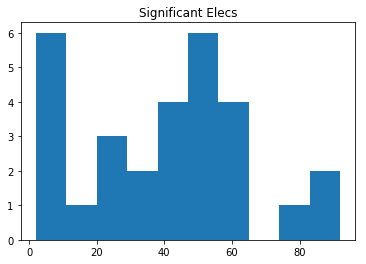

In [290]:
## put sig delays in hist
delays = []
for d in range(len(data['elecs'])):
    if data['elecs'][d] in sig:
        delays.append(data['delay'][d])

print(len(delays))
plt.hist(delays)
plt.title('Significant Elecs')
plt.show()
        

#### visulaize data

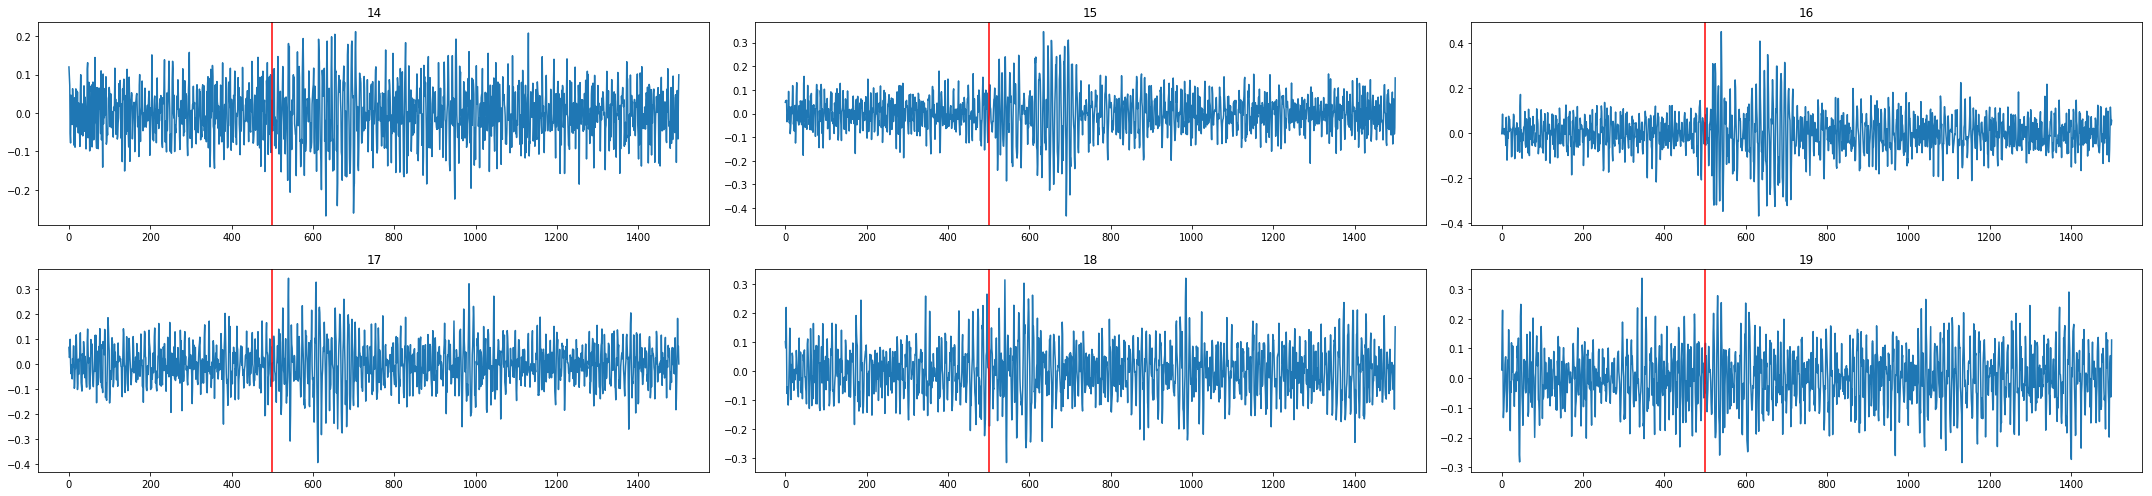

In [309]:
plt.figure(figsize = (30,7))


elecs = [13,14,15,16,17,18]
i = 1
for e in elecs:
    plt.subplot(2,3,i)
    myhg = np.mean(hg_stim[:, :, e], axis = 0)
#     myhg = abs(myhg)
    plt.plot(myhg)
    plt.title(e+1)
    plt.axvline(x=500, color = 'r')
    i += 1
plt.tight_layout()
plt.show()


In [570]:
myhg = np.mean(hg_stim[:, :, 0], axis = 0)
myhg= abs(myhg)
time_series =myhg
cb = np.array(time_series)
indices = peakutils.indexes(cb, thres=0.02/max(cb), min_dist=0.1)

trace = go.Scatter(
    x=[j for j in range(len(time_series))],
    y=time_series,
    mode='lines',
    name='Original Plot'
)

trace2 = go.Scatter(
    x=indices,
    y=[time_series[j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='rgb(255,0,0)',
        symbol='cross'
    ),
    name='Detected Peaks'
)

data = [trace, trace2]
py.iplot(data, filename='test')

In [465]:
def get_peaks(myhg):
    '''finds the peaks for a given data set and plots a graph'''
    myhg= abs(myhg)
    time_series = myhg[(time_axis >= 500) & (time_axis <= 600)]
    cb = np.array(time_series)
    indices = peakutils.indexes(cb, thres=0.02/max(cb), min_dist=0.1)

    trace = go.Scatter(
        x=[j for j in range(len(time_series))],
        y=time_series,
        mode='lines',
        name='Original Plot'
    )

    trace2 = go.Scatter(
        x=indices,
        y=[time_series[j] for j in indices],
        mode='markers',
        marker=dict(
            size=8,
            color='rgb(255,0,0)',
            symbol='cross'
        ),
        name='Detected Peaks'
    )

    data = [trace, trace2]
    return trace2

In [87]:
x = get_peaks(myhg)

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~ashafi/0 or inside your plot.ly account where it is named 'milk-production-plot-with-peaks'


## Get delay for each electrode and each trial sep.

In [115]:
##go through all elecs, get peaks for each elec at each trial and put peak into dataframe 
list_of_first_peaks = []
elecs = []
trials = []
for i in range(256):
    for j in range(300):
        #get data for each trial, j, and each elec, i
        myhg = hg_stim[j, :, i]
        myhg = abs(myhg)
        
        #get peaks
        peaks = get_peaks(myhg)
        first_peak =np.percentile(peaks['y'], 95)
        indx = np.where(peaks['y'] > first_peak)
        
        #get delay
        delay = peaks['x'][indx[0][0]]
        list_of_first_peaks.append(delay)
        elecs.append(i)
        trials.append(j)
        print(i)
        
    

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
1

24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
2

34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
3

44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
44
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
4

54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
5

64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
6

74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
76
76
76
76
76
76
76
76
76
76
76
76
76
7

86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
8

96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
96
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
97
9

104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105


112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113
113


121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121


129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130
130


137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
137
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138
138


146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146
146


154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155


162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163
163


170
170
170
170
170
170
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171


178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
178
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179


186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
186
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187


194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195


202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203


210
210
210
210
210
210
210
210
210
210
210
210
210
210
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211


219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220


226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
226
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227


234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235


242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
242
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243


251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251


In [ ]:
### get average for the by trials
end = 299
start = 0
avgs = []
for e in range(256):
    avg = sum(list_of_first_peaks[start:end])/300
    end += 300
    start += 300
    avgs.append(avg)

## Get delays for each electrode averaged for each trial
#### This is the code we should use

In [237]:
list_of_first_peaks = []
elecs = []
for i in range(256):
        #get data for each trial, j, and each elec, i
    myhg = np.mean(hg_stim[:, :, i], axis = 0)
    myhg = abs(myhg)

    #get peaks
    peaks = get_peaks(myhg)
    first_peak =np.percentile(peaks['y'], 95)
    indx = np.where(peaks['y'] > first_peak)

    #get delay
    delay = peaks['x'][indx[0][0]]
    list_of_first_peaks.append(delay)
    elecs.append(i)
    print(i)
    
    

data = pd.DataFrame()
data['elecs'] = elecs
data['delay'] = list_of_first_peaks


NameError: name 'get_peaks' is not defined

In [32]:
## take sig elecs only 
only_sig_elecs = pd.DataFrame()
delays = []
for d in range(len(data['elecs'])):
    if data['elecs'][d] in sig:
        delays.append(data['delay'][d])
only_sig_elecs['elecs'] = sig
only_sig_elecs['delays'] = delays

In [37]:
sum(only_sig_elecs['delays'])/len(only_sig_elecs)

39.172413793103445

In [35]:
for e in range(len(only_sig_elecs['delays'])):
    if only_sig_elecs['delays'][e] <= 20: 
        print(only_sig_elecs['elecs'][e])

39
166
172
173
174
189
190
225
239


In [195]:
## find average for all elecs
sum(data['delay'])/256

34.96484375

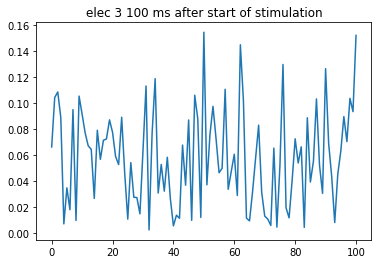

In [201]:
### Check data to see what it looks like
myhg = np.mean(hg_stim[:, :, 26], axis = 0)
myhg = abs(myhg)
plt.plot(myhg[(time_axis >= 500) & (time_axis <= 600)])
plt.title('elec 3 100 ms after start of stimulation')
plt.show()


In [173]:
delays = pd.DataFrame()
delays['elecs'] = list(range(256))
delays['delay'] = list_of_first_peaks
delays.to_csv('delay_click_avg.csv')

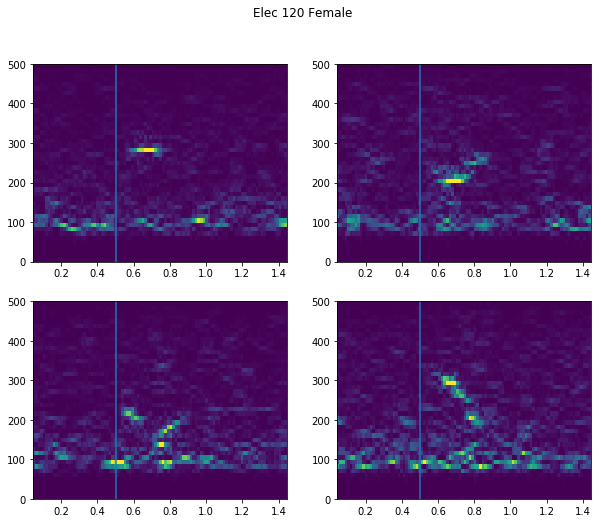

In [30]:
plt.figure(figsize = (10,8))
iterplot = 1
tone = [1,2,3,4]
for i in tone:
    plt.subplot(2,2, iterplot)
    indx1 = np.where((behav['speaker'] == 'i') & (behav['tone'] == i))[0]
    indx2 = np.where((behav['speaker'] == 'h') & (behav['tone'] == i))[0]
    indx = np.append(indx1,indx2)
    myhg = np.mean(hg_stim[indx, :, 119], axis = 0)
    f,t, Sxx = signal.spectrogram(myhg, 1000, noverlap = 76, nperseg =90)
    plt.pcolormesh(t,f,Sxx, vmax = np.percentile(Sxx.flatten(), 99.9))
    iterplot += 1
plt.suptitle('Elec 120 Female')
plt.show()


In [12]:
behav

,accuracy,block,choice,rt,speaker,syllable,tone,trial,Trial,file
0,1,1,2,4.03,b,bu,2,1,0,bu2-bN
1,1,1,2,3.49,b,ma,2,2,1,ma2-bN
2,0,1,2,4.12,b,ma,4,3,2,ma4-bN
3,1,1,2,2.19,b,ma,2,4,3,ma2-bN
4,1,1,4,3.48,b,bu,4,5,4,bu4-bN
5,1,1,4,4.32,b,bu,4,6,5,bu4-bN
6,1,1,2,2.87,b,ma,2,7,6,ma2-bN
7,1,1,4,2.81,b,ma,4,8,7,ma4-bN
8,1,1,4,2.68,b,bu,4,9,8,bu4-bN
9,1,1,2,2.22,b,bu,2,10,9,bu2-bN


## Go back to Mandarin Tones & find cross correlation

In [5]:
# Where are the data?
dir_data = ''.join([root_dir, '/', subj, '/data'])
file_ECoG = ''.join([dir_data, '/', subj, '_dat_FFR_noCAR_notch_hp_allTrials.mat'])
# file_ECoG = ''.join([dir_data, '/', subj, '_dat_FFR.mat'])

# Load the .mat file
f = h5py.File(file_ECoG, 'r')

# Read ECoG data
hg_stim = np.array(f['dat']['hg_stim']) # trial * tp * ch
badChans = f['dat']['badChans'].value.flatten() - 1 # Correct for 0-indexing
time_axis = (np.round(f['dat']['time_axis'].value.flatten(), 3) * 1000).astype(int) # Use int b/c float precision


# Import behav
list_col = ['accuracy', 'block', 'choice', 'rt', 'speaker', 'syllable', 'tone', 'trial']
behav = pd.DataFrame(columns = list_col)
for icol in list_col:
    if np.in1d(icol, ['speaker', 'syllable']):
        for i in range(0, behav.shape[0]):
            behav.loc[i, icol] = ''.join(map(chr, f[f['dat']['behav'][icol][0,i]]))
    else:
        behav[icol] = np.array(f['dat']['behav'][icol]).flatten()
        
for icol in ['accuracy', 'block', 'choice', 'tone', 'trial']:
    behav[icol] = behav[icol].astype(int)
    
f.close()

#extract data from 0-500 ms 


# Get rid of NaN trials, if any
if np.in1d(subj, ['EC157','EC159', 'UI399']):
    nanTrial = np.unique(np.where(np.isnan(hg_stim))[0])
    if nanTrial.shape[0] > 0: # perform only if NaN trials exist at all
        hg_stim = np.delete(hg_stim, nanTrial, 0)
        behav = behav.drop(nanTrial, axis = 0).reset_index(drop = True)

# What are the "good" channels?
good_ch_vector = np.ones((hg_stim.shape[2])).astype(int)
good_ch_vector[badChans] = 0
goodChans = np.where(good_ch_vector)[0]
    
# Create index for behav (not literally the trial)
behav['Trial'] = range(0, behav.shape[0])

# Add the "file" column
behav['file'] = behav['syllable'].astype(str) + behav['tone'].astype(str) + '-' + behav['speaker'].astype(str) + 'N'

## Autocorrelation

In [6]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    #"full" mode returns results for every t where both a and v have some overlap.
    #"same" mode returns a result with the same length as the shortest vector (a or v).
    #"valid" mode returns results only when a and v completely overlap each other. The documentation for numpy.convolve gives more detail on the modes.
    return result[result.size/2:]

#### Read stim and put into data frame

In [6]:
## get list of tones
tones = np.unique(behav['file'])
tones = tones.tolist()

In [35]:
'''this reads each wav file, zero pads it to match the FFR, runs autocorr on all stimuli and then 
    normalizing from -1 to 1'''
import scipy.io
import os

'''autocorr the stimulation wav files t = tone, p = b or h, male or female'''
dirs = os.listdir('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/')
dataStim = pd.DataFrame()
positive = np.zeros((558,))
negative = np.zeros((500,))


for i in dirs:
    y, sr= librosa.load('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/' + i, sr = 1000)
#     y = np.append(y,positive)
#     y = np.insert(y,0,negative)
    dataStim[i] = y

In [79]:
def get_peaks_stim(stim):
    myhg = stim
    myhg= abs(myhg)
    time_series = myhg[(time_axis >= 0) & (time_axis <= 500)]
    cb = np.array(time_series)
    indices = peakutils.indexes(cb, thres=0.02/max(cb), min_dist=0.1)

    trace = go.Scatter(
        x=[j for j in range(len(time_series))],
        y=time_series,
        mode='lines',
        name='Original Plot'
    )

    trace2 = go.Scatter(
        x=indices,
        y=[time_series[j] for j in indices],
        mode='markers',
        marker=dict(
            size=8,
            color='rgb(255,0,0)',
            symbol='cross'
        ),
        name='Detected Peaks'
    )

    data = [trace, trace2]
    return trace2

In [9]:
plt.figure(figsize = (5,10))
n = 1
for s in dataStim:
#         plt.subplot(5,4,n)
        f,t, Sxx = signal.spectrogram(dataStim[s], 1000, noverlap = 76, nperseg =90)
        plt.pcolormesh(t,f,Sxx, vmax = np.percentile(Sxx.flatten(), 99.9))
        plt.title(s, fontsize = 20)
        n+=1
        

#### put stims in groups of freq ranges

In [387]:
greater200 = ['bu4-iN', 'ma4-iN', 'mi4-iN', 'di4-hN', 'di2-iN', 'bu4-aN', 'lu4-hN','bu3-bN', 'di3-aN', 'lu4-iN'
             , 'bu4-hN', 'ma4-hN', 'mi4-hN', 'di4-iN', 'di2-iN', 'di-hN', 'bu4-bN', 'bu1-iN', 'mi1-iN', 'ma1-iN', 'lu1-hN', 'lu1-iN',
             'di1-iN' 'bu1-hN', 'mi1-hN', 'di4-bN', 'ma1-hN']

hz200 = ['ma2-hN', 'mi2-hN', 'bu2-hN', 'mi1-bN', 'ma1-bN', 'bu1-bN', 'mi4-aN', 'lu2-iN', 'di4-aN', 'lu2-iN', 'lu1-bN',
        'di4-aN', 'lu2-hN', 'ma2-iN', 'mi2-iN', 'di1-bN', 'lu4-aN', 'ma4-bN', 'lu3-hN', 'mi4-bN', 'di3-hN', 'ma3-iN',
        'mi3-iN', 'di3-iN','di1-aN','ma3-hN','lu4-bN', 'mi3-hN', 'lu1-aN']

hz125to150 = ['lu2-aN', 'ma4-aN', 'ma3-bN', 'mi3-bN', 'di2-aN', 'mi2-aN', 'di2-bN', 'mi1-aN', 'lu2-bN', 'ma1-aN', 'bu7-aN',
             'ma2-bN', 'mi2-bN']
hz100 = ['ma2-aN', 'ma3-aN', 'mi3-aN']

### find the largest fq in the spectrum for each stim

In [9]:
fq = []
stim = []
for s in dataStim:
    myspec = np.fft.rfft(dataStim[s])
    plt.plot(np.linspace(0, 500, myspec.shape[0]), abs(myspec))
    peaks = get_peaks_stim(myspec)
    indx = np.where(peaks['y'] == max(peaks['y']))
    hz = peaks['x'][indx]
    fq.append(hz)
    stim.append(s)

StimFq = pd.DataFrame()
StimFq['stim'] = stim
StimFq['hz'] = fq

/Users/alia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning:

boolean index did not match indexed array along dimension 0; dimension is 222 but corresponding boolean dimension is 1501



IndexError: index 500 is out of bounds for axis 1 with size 222

In [17]:
len()

442

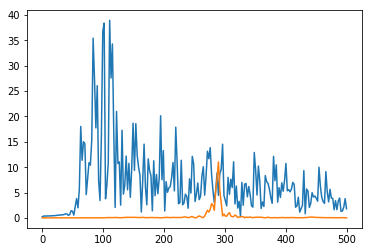

In [22]:
indx = np.where((behav['file'] == 'ma1-iN'))[0]
myhg = np.mean(hg_stim[indx, :, 15], axis = 0)

myspec1 = np.fft.rfft(myhg[571:1013])
plt.plot(np.linspace(0, 500, myspec1.shape[0]), abs(myspec1))


myspec = np.fft.rfft(dataStim['ma1-iN.wav'])
plt.plot(np.linspace(0, 500, myspec.shape[0]), abs(myspec))
plt.show()
# get_peaks_stim(myspec)

## Read FFR for all trials and put in DataFrame

In [223]:
import pandas as pd
import itertools
import matplotlib as pyplot

def get_FFR(e,d):
    '''takes elec and gets FFR data for ever stim assuming a 'd' ms delay'''
    dataFFR = pd.DataFrame()
    test = np.where((behav['block'] <22))[0]

    for f in test:
        file = behav['file'][f]
        myhg = hg_stim[f, :, e] ## for only electrode 15
        dataFFR[file + '_' + str(f)] = myhg[500+d:942+d] ###Assuming a 'd' ms delay

    return dataFFR

## Run cross correlation on stim to response (assuming 40 ms delay)

In [221]:
def get_crosscorr_all(data):
    '''takes in data - a given FFR data - and runs cross correlation for all stim'''
    cors53 = pd.DataFrame()##because each stim was a different length
    cors11 = pd.DataFrame()
    cors58 = pd.DataFrame()
    cors3 = pd.DataFrame()
    for s in dataStim:
        correlation = []
        for f in data:
            if s[0:6] == f[0:6]:
                ## find matching stim to FFR and run correlation
                myhg = sklearn.preprocessing.scale(data[f])
                stim = sklearn.preprocessing.scale(dataStim[s])
                cor = np.corrcoef(stim, myhg)[1,0]
                correlation.append(cor)
        flat_list = correlation
        ## put correlation values in dataframe depending on length of frame
        if len(flat_list) == 3:
            cors3[s] = flat_list
        if len(flat_list) == 11:
            cors11[s] = flat_list
        if len(flat_list) == 53:
            cors53[s] = flat_list
        if len(flat_list) == 58:
            cors58[s] = flat_list
        
    correlations = pd.concat([cors53,cors58,cors11,cors3],ignore_index=False, axis=1)
    return correlations


## average over stimulus and then calculate correlation with a 34 ms delay

#### get data with delay

In [644]:
dataFFR = get_FFR(15,71)
large_enough = []
testing = []
lens = []
num_trials_per_stim = pd.DataFrame()
for s in dataStim:
    stims = []
    correlation = []
    count = 0
    testing.append(s)
    for f in dataFFR:
        if s[0:6] == f[0:6]:
            stims.append(s)
    lens.append(len(stims))
    if len(stims) >= 53: 
        large_enough.append(s)
large_enough.sort()
num_trials_per_stim['stim'] = testing
num_trials_per_stim['number of trials'] = lens
# num_trials_per_stim

In [635]:
## this takes the average of each stimulus with more than 52 trials
data_by_stim = pd.DataFrame()
for x in large_enough:
    indx = np.where((behav['file'] == x[0:6]))[0]
    np.random.shuffle(indx)
    myhg = np.mean(hg_stim[indx[0:52], :, 15], axis = 0)## to make them all the same size
    data_by_stim[x] = myhg[500+71:942+71] ## averaged stim

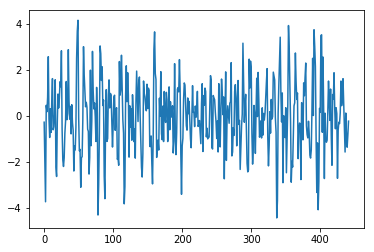

In [33]:
plt.plot(dataFFR['bu2-bN_0'])
plt.show()

In [8]:
dataFFR = get_FFR(15,71)


In [70]:
dataFFR = dataFFR['bu2-bN_0']
a = []
for b in dataFFR:
    a.append(b)
    
z = []    
for x in dataStim1:
    z.append(x)
# test1 = [a.append(b) for b in dataFFR]

In [79]:
a = np.array(a)
b = a.ravel()
z = np.array(z)
c = z.ravel()

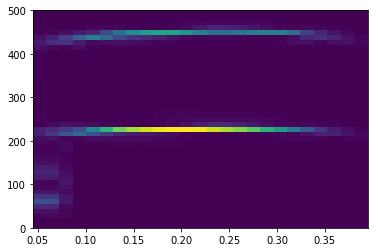

In [38]:
myhg = dataStim['bu1-bN.wav']
f,t, Sxx = signal.spectrogram(myhg, 1000, noverlap = 76, nperseg =90)
plt.pcolormesh(t,f,Sxx, vmax = np.percentile(Sxx.flatten(), 99.9))
plt.show()

In [236]:
# s = []
# cors = []
# for a in dataStim:
#     stim = a[0:6]
indx = np.where((behav['file'] == 'di3-aN'))[0]
trial = []
cors = []
s = []
for i in indx:
    print(i)
    trial.append(i)
    myhg = hg_stim[i, :, 15]
    myhg = sklearn.preprocessing.scale(myhg)
    Stims = sklearn.preprocessing.scale(dataStim[a])
    cor = np.corrcoef(myhg[500:942], Stims)
    cors.append(cor[0][1])
    s.append(stim)


271


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [231]:
plt.scatter(trial,cors)
plt.show()

ValueError: x and y must be the same size

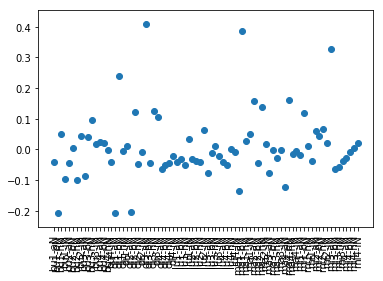

di3-aN


In [208]:
data = pd.DataFrame()
data['cor'] = cors
data['stim'] = s

# plt.plot(cors)
# plt.show()

plt.scatter(s,cors)
plt.xticks(rotation = 90)
plt.show()

i = np.where(cors == max(cors))
t = i[0][0]

print(s[t])

0.10630708663667544
(array([13]), array([48]))


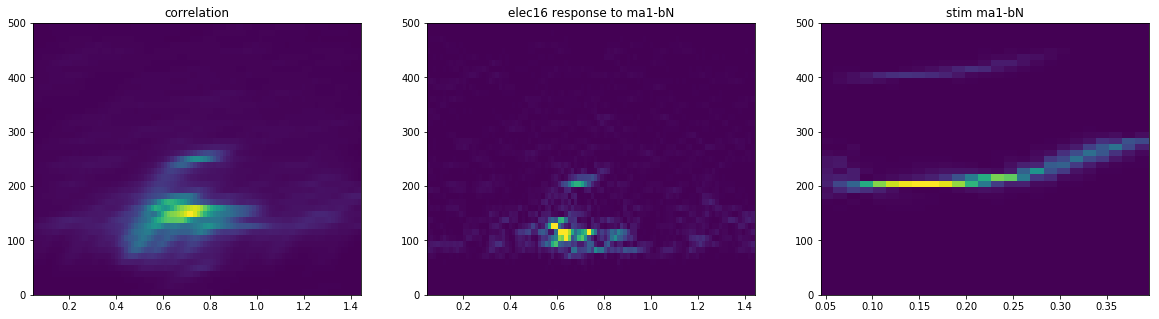

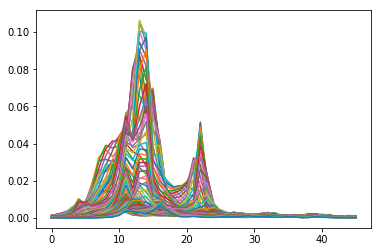

array([[1.      , 0.137571],
       [0.137571, 1.      ]])

In [177]:
import sklearn
indx = np.where((behav['file'] == 'ma2-hN'))[0]
myhg = np.mean(hg_stim[indx, :, 15], axis = 0)
myhg = sklearn.preprocessing.scale(myhg)


stim = sklearn.preprocessing.scale(dataStim['ma2-hN.wav'])

f,t, SxxFFR = signal.spectrogram(myhg, 1000, noverlap = 76, nperseg =90)
fs,ts, SxxStim = signal.spectrogram(stim, 1000, noverlap = 76, nperseg =90)
ff,tf, SxxFFR = signal.spectrogram(myhg, 1000, noverlap = 76, nperseg =90)





correlation_array = signal.correlate2d(SxxFFR,SxxStim, mode= "same")
best_shift = np.max(correlation_array)
shift_itself = np.where(correlation_array == best_shift)
# shift_itself = correlation_array.tolist().index(best_shift);
print(best_shift)
print(shift_itself)
len(myhg) 

# plt.pcolormesh(t,f,correlation_array)
# plt.title('ma1-bN')
# plt.show()


plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plt.pcolormesh(t,f,correlation_array)
plt.title('correlation')

plt.subplot(1,3,2)
plt.pcolormesh(tf,ff,SxxFFR, vmax = np.percentile(SxxStim.flatten(), 99.9))
plt.title('elec16 response to ma1-bN')


plt.subplot(1,3,3)
plt.pcolormesh(ts,fs,SxxStim, vmax = np.percentile(SxxStim.flatten(), 99.9))
plt.title('stim ma1-bN')
plt.show()

plt.plot(correlation_array)
plt.show()

np.corrcoef(myhg[500:942], stim)

In [141]:
y,x = np,where(correlation_array == mac)


In [169]:
correlation_array.shape

(46, 101)

/Users/alia/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning:

Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.

/Users/alia/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning:

Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.



195.6784530580556
755


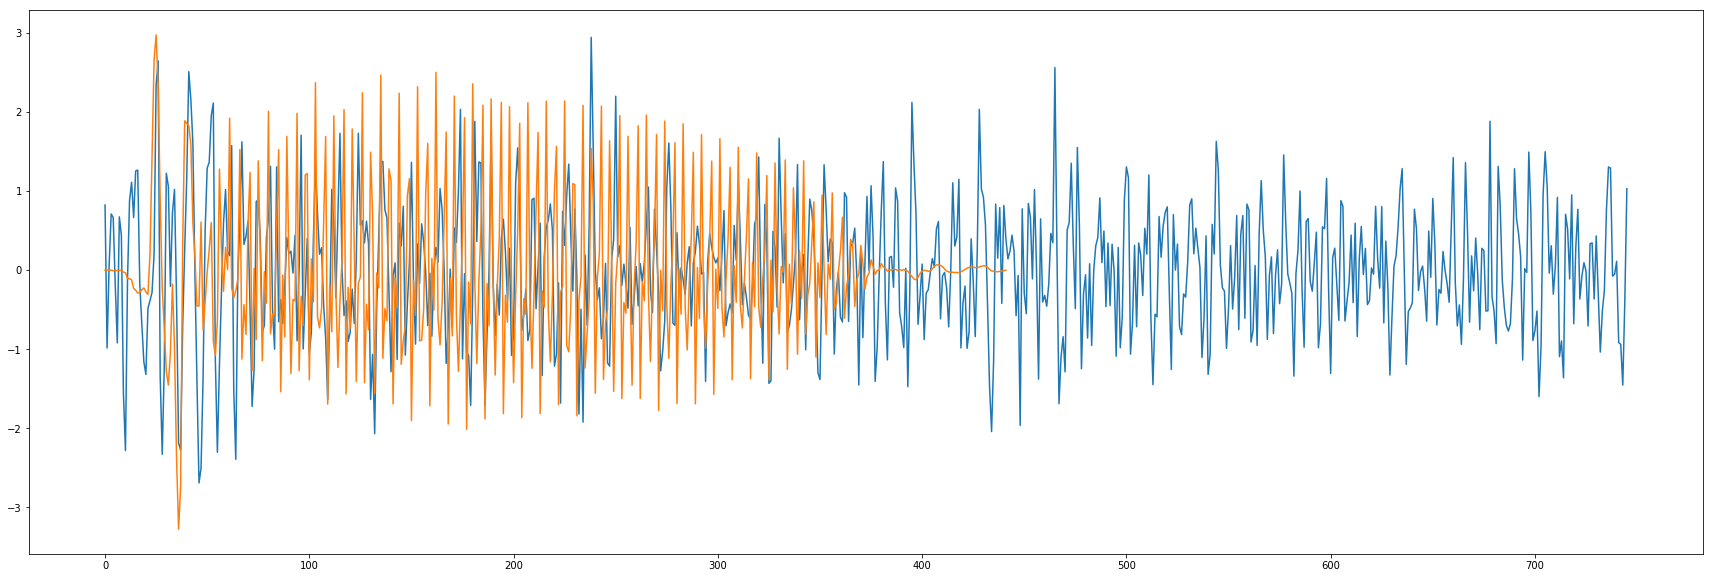

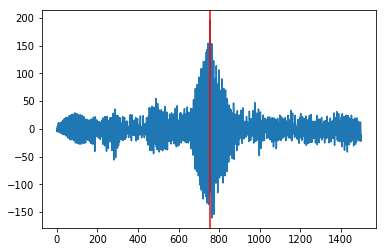

In [14]:
# dataFFR1 = dataFFR['bu2-bN_0']
dataStim1 = dataStim['bu1-bN.wav']

indx = np.where((behav['file'] == 'bu1-bN'))[0]
myhg = np.mean(hg_stim[indx, :, 15], axis = 0)
myhg = sklearn.preprocessing.scale(myhg)

stim = sklearn.preprocessing.scale(dataStim1)


# f,t, Sxx1 = signal.spectrogram(dataFFR1, 1000, noverlap = 76, nperseg =90)
# f,t, Sxx2 = signal.spectrogram(dataStim1, 1000, noverlap = 76, nperseg =90)

correlation_array = signal.correlate(myhg,stim, mode= "same", method = "fft")
best_shift = np.max(correlation_array)
shift_itself = correlation_array.tolist().index(best_shift);
print(best_shift)
print(shift_itself)
len(myhg)

# plt.pcolormesh(t,f,Sxx, vmax = np.percentile(Sxx.flatten(), 99.9))
plt.figure(figsize = (30,10))
signal3 = myhg[shift_itself:]
plt.plot(signal3)
plt.plot(stim)
plt.show()

plt.plot(correlation_array)
plt.axvline(x=shift_itself, color = 'r')
plt.show()



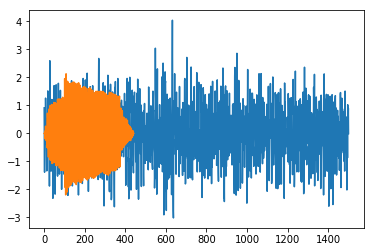

In [73]:
import sklearn 
indx = np.where((behav['file'] == 'ma1-iN'))[0]
dataStim1 = dataStim['ma1-iN.wav']
myhg = np.mean(hg_stim[indx, :, 15], axis = 0)
myhg1 = sklearn.preprocessing.scale(myhg1)
stim = sklearn.preprocessing.scale(dataStim1)

plt.plot(myhg1)
plt.plot(stim)
plt.show()

## Plot all correlation values

In [664]:
test = get_crosscorr_all(dataFFR)
stim = []
data = []
for s in test:
    for z in range(len(test)):
        stim.append(s)
        data.append(test[s][z])
        
SC = pd.DataFrame()        
SC['stim'] = stim
SC['cors'] = data

In [672]:
stim = []
a = []
test = get_crosscorr_all(dataFFR)
for t in test:
    avg = np.nanmean(test[t])
    stim.append(t)
    a.append(avg)
    
Avrg = pd.DataFrame()
Avrg['stim'] = stim
Avrg['avg'] = a

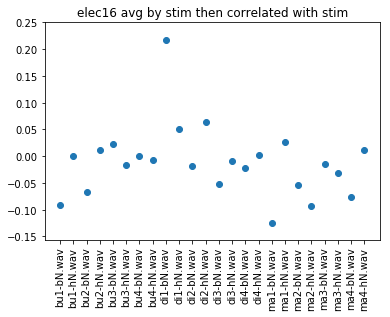

In [636]:
cors = []
stim_cor = []
SC = pd.DataFrame()
for a in data_by_stim:
    correlation = []
    stim_cor.append(d)
    for b in dataStim:
        if a == b:
            cor = np.corrcoef(dataStim[a], data_by_stim[b])[1,0]
            correlation.append(cor)
            cors.append(cor)
plt.scatter(large_enough,cors)
plt.xticks(rotation = 90)
plt.title('elec16 avg by stim then correlated with stim')
plt.show()

SC['stim'] = large_enough
SC['cors'] = cors
# SC.to_csv('correlations_by_avg_stim.csv')

In [643]:
np.corrcoef(SC['hz'], SC['cors'])[0][1]

0.1344210634683207

In [676]:
l = []
for s in range(len(Avrg['stim'])):
    for f in range(len(StimFq['stim'])):
        if Avrg['stim'][s][0:6] == StimFq['stim'][f][0:6]:
            l.append(StimFq['hz'][f][0])
Avrg['hz'] = l

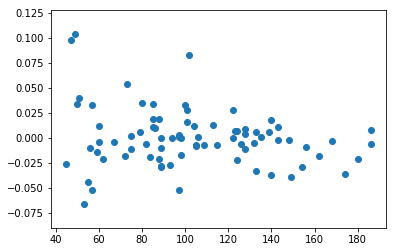

In [680]:
plt.scatter(Avrg['hz'], Avrg['avg'])
plt.show()


In [222]:
dataFFR16 = get_FFR(15,71)
data_by_stim_16 = get_crosscorr_all(dataFFR16)

dataFFR120 = get_FFR(119,38)
data_by_stim_120 = get_crosscorr_all(dataFFR120)

newdf16 = pd.DataFrame()
newdf120 = pd.DataFrame()
for s in data_by_stim_16:
#     if s[0:6] in greater200:
    newdf16[s] = data_by_stim_16[s]

for s in data_by_stim_120:
#     if s[0:6] in greater200:
    newdf120[s] = data_by_stim_120[s]
    
plt.figure(figsize = (15,12))
plt.subplot(2,2,1)
sns.boxplot(data = newdf16)
plt.xticks(rotation=90, size = 15)
plt.yticks(size = 15)
plt.title('elec16')

plt.subplot(2,2,2)
sns.boxplot(data = newdf120)
plt.xticks(rotation=90, size = 15)
plt.yticks(size = 15)
plt.title('elec120')
plt.show()


NameError: name 'get_FFR' is not defined

In [463]:
c = []
file = []
elec = []
for j in newdf16:
    if j == 'ma4-aN.wav':
        for s in range(len(newdf16)):
            file.append(j)
            c.append(newdf16[j][s])
            elec.append(16)
    if j == 'di4-aN.wav':
        for s in range(len(newdf16)):
            file.append(j)
            c.append(newdf16[j][s])
            elec.append(16)
for a in newdf120:
    if a == 'ma4-aN.wav':
        for b in range(len(newdf120)):
            file.append(a)
            c.append(newdf120[a][b])
            elec.append(120)
    if a == 'di4-aN.wav':
        for b in range(len(newdf120)):
            file.append(a)
            c.append(newdf120[a][b])
            elec.append(120)

Orgz = pd.DataFrame()
Orgz['elec'] = elec
Orgz['stim'] = file
Orgz['cors'] = c




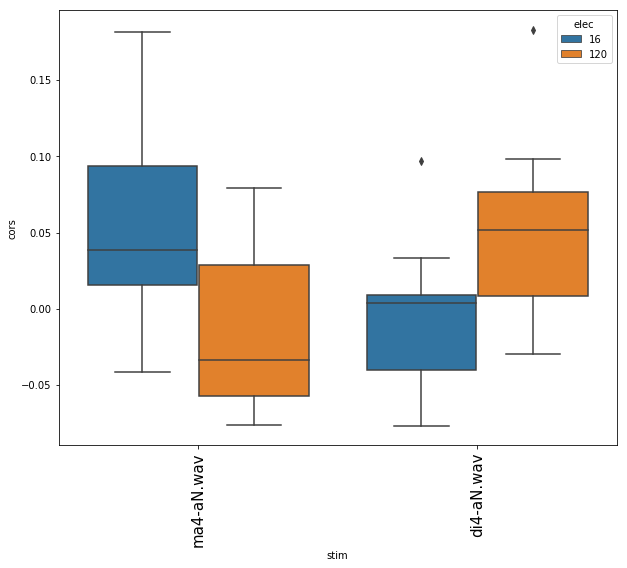

In [464]:
plt.figure(figsize = (10,8))
sns.boxplot(x = 'stim', y = "cors", hue = 'elec', data = Orgz)
plt.xticks(rotation=90, size = 15)

plt.show()

In [428]:
sex = []
tone = []
for x in SC['stim']:
    a = int(x[2])
    tone.append(a)
    if x[4] == 'h':
        sex.append('female')
    if x[4] =='b':
        sex.append('male')




SC['sex'] = sex
SC['tone'] = tone



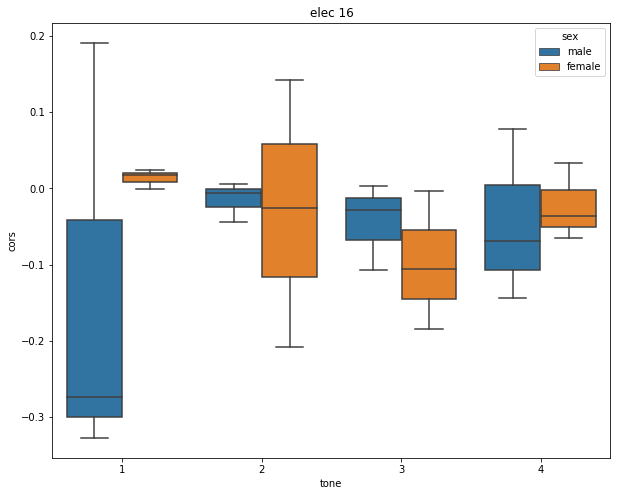

In [429]:
plt.figure(figsize = (10,8))
sns.boxplot(x = 'tone', y = "cors", hue = 'sex', data = SC)
plt.title('elec 16')
plt.show()

In [348]:
##make a df for a pretty boxplot
def new_df(df, t):
    sex = []
    Tone1 = []
    sexs = []
    test = []
    tone = []
    for i in df:
        if 'b'== i[-6]:
            sex.append('male')
        if 'a'== i[-6]:
            sex.append('male')
        else:
            sex.append('female')

    num = 0
    for x in df:
        for j in df[x]:
            Tone1.append(j)
            sexs.append(sex[num])
            test.append(x)
            tone.append(t)
        num += 1

    Tone1df = pd.DataFrame()
    Tone1df['cors'] = Tone1
    Tone1df['Tone'] = tone
    Tone1df['sex'] = sexs
    return Tone1df

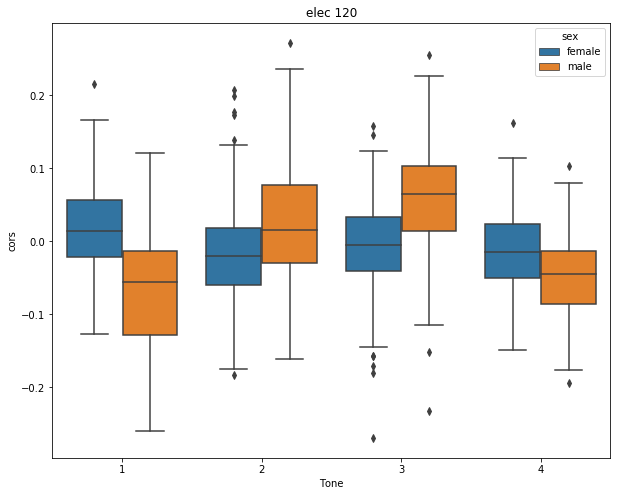

In [349]:
plt.figure(figsize = (10,8))

Tone1 = new_df(correlations1,1)
Tone2 = new_df(correlations2,2)
Tone3 = new_df(correlations3,3)
Tone4 = new_df(correlations4,4)

Tones = pd.DataFrame()
Tones = Tones.append(Tone1)
Tones = Tones.append(Tone2)
Tones = Tones.append(Tone3)
Tones = Tones.append(Tone4)


sns.boxplot(x = 'Tone', y = "cors", hue = 'sex', data = Tones)
plt.title('elec 120')
plt.show()

In [224]:
dataFFR = get_FFR(119,38)
correlations = get_crosscorr_all(dataFFR)


/Users/alia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning:

Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 



In [225]:
#separates correlations into tones
correlations2 = pd.DataFrame()
correlations1 = pd.DataFrame()
correlations3 = pd.DataFrame()
correlations4 = pd.DataFrame()
for c in correlations:
    if '2' in c:
        correlations2[c] = correlations[c]
    if '1' in c:
        correlations1[c] = correlations[c]
    if '3' in c:
        correlations3[c] = correlations[c]
    if '4' in c:
        correlations4[c] = correlations[c]



In [226]:
def sort_df(df):
    l = []
    for i in df:
        l.append(i)
    l.sort()
    return l

a = sort_df(correlations1)
correlations1M = correlations1.reindex_axis((a), axis = 1)

b = sort_df(correlations2)
correlations2M = correlations2.reindex_axis((b), axis = 1)

c = sort_df(correlations3)
correlations3M = correlations3.reindex_axis((c), axis = 1)

d = sort_df(correlations4)
correlations4M = correlations4.reindex_axis((d), axis = 1)

In [383]:

# sns.boxplot(data = [correlations1F, correlations2F, correlations3F, correlations4F, correlations1M, correlations2M, correlations3M, correlations4M] )
# plt.show()

In [385]:
# sns.boxplot(data = [correlations1, correlations2, correlations3, correlations4])
# plt.show()

In [227]:
dfs = [correlations1, correlations2, correlations3, correlations4]
test = pd.DataFrame()
meds = []
store = []
for d in dfs:
    med = d.median()
    for m in med:
        meds.append(m)
    for item in d:
        store.append(item)
        

test['median'] = meds
test['stims'] = store
interesting_stims = []
for t in range(len(test)):
    if test['median'][t] > 0.05:
        interesting_stims.append(test['stims'][t])
# 
    

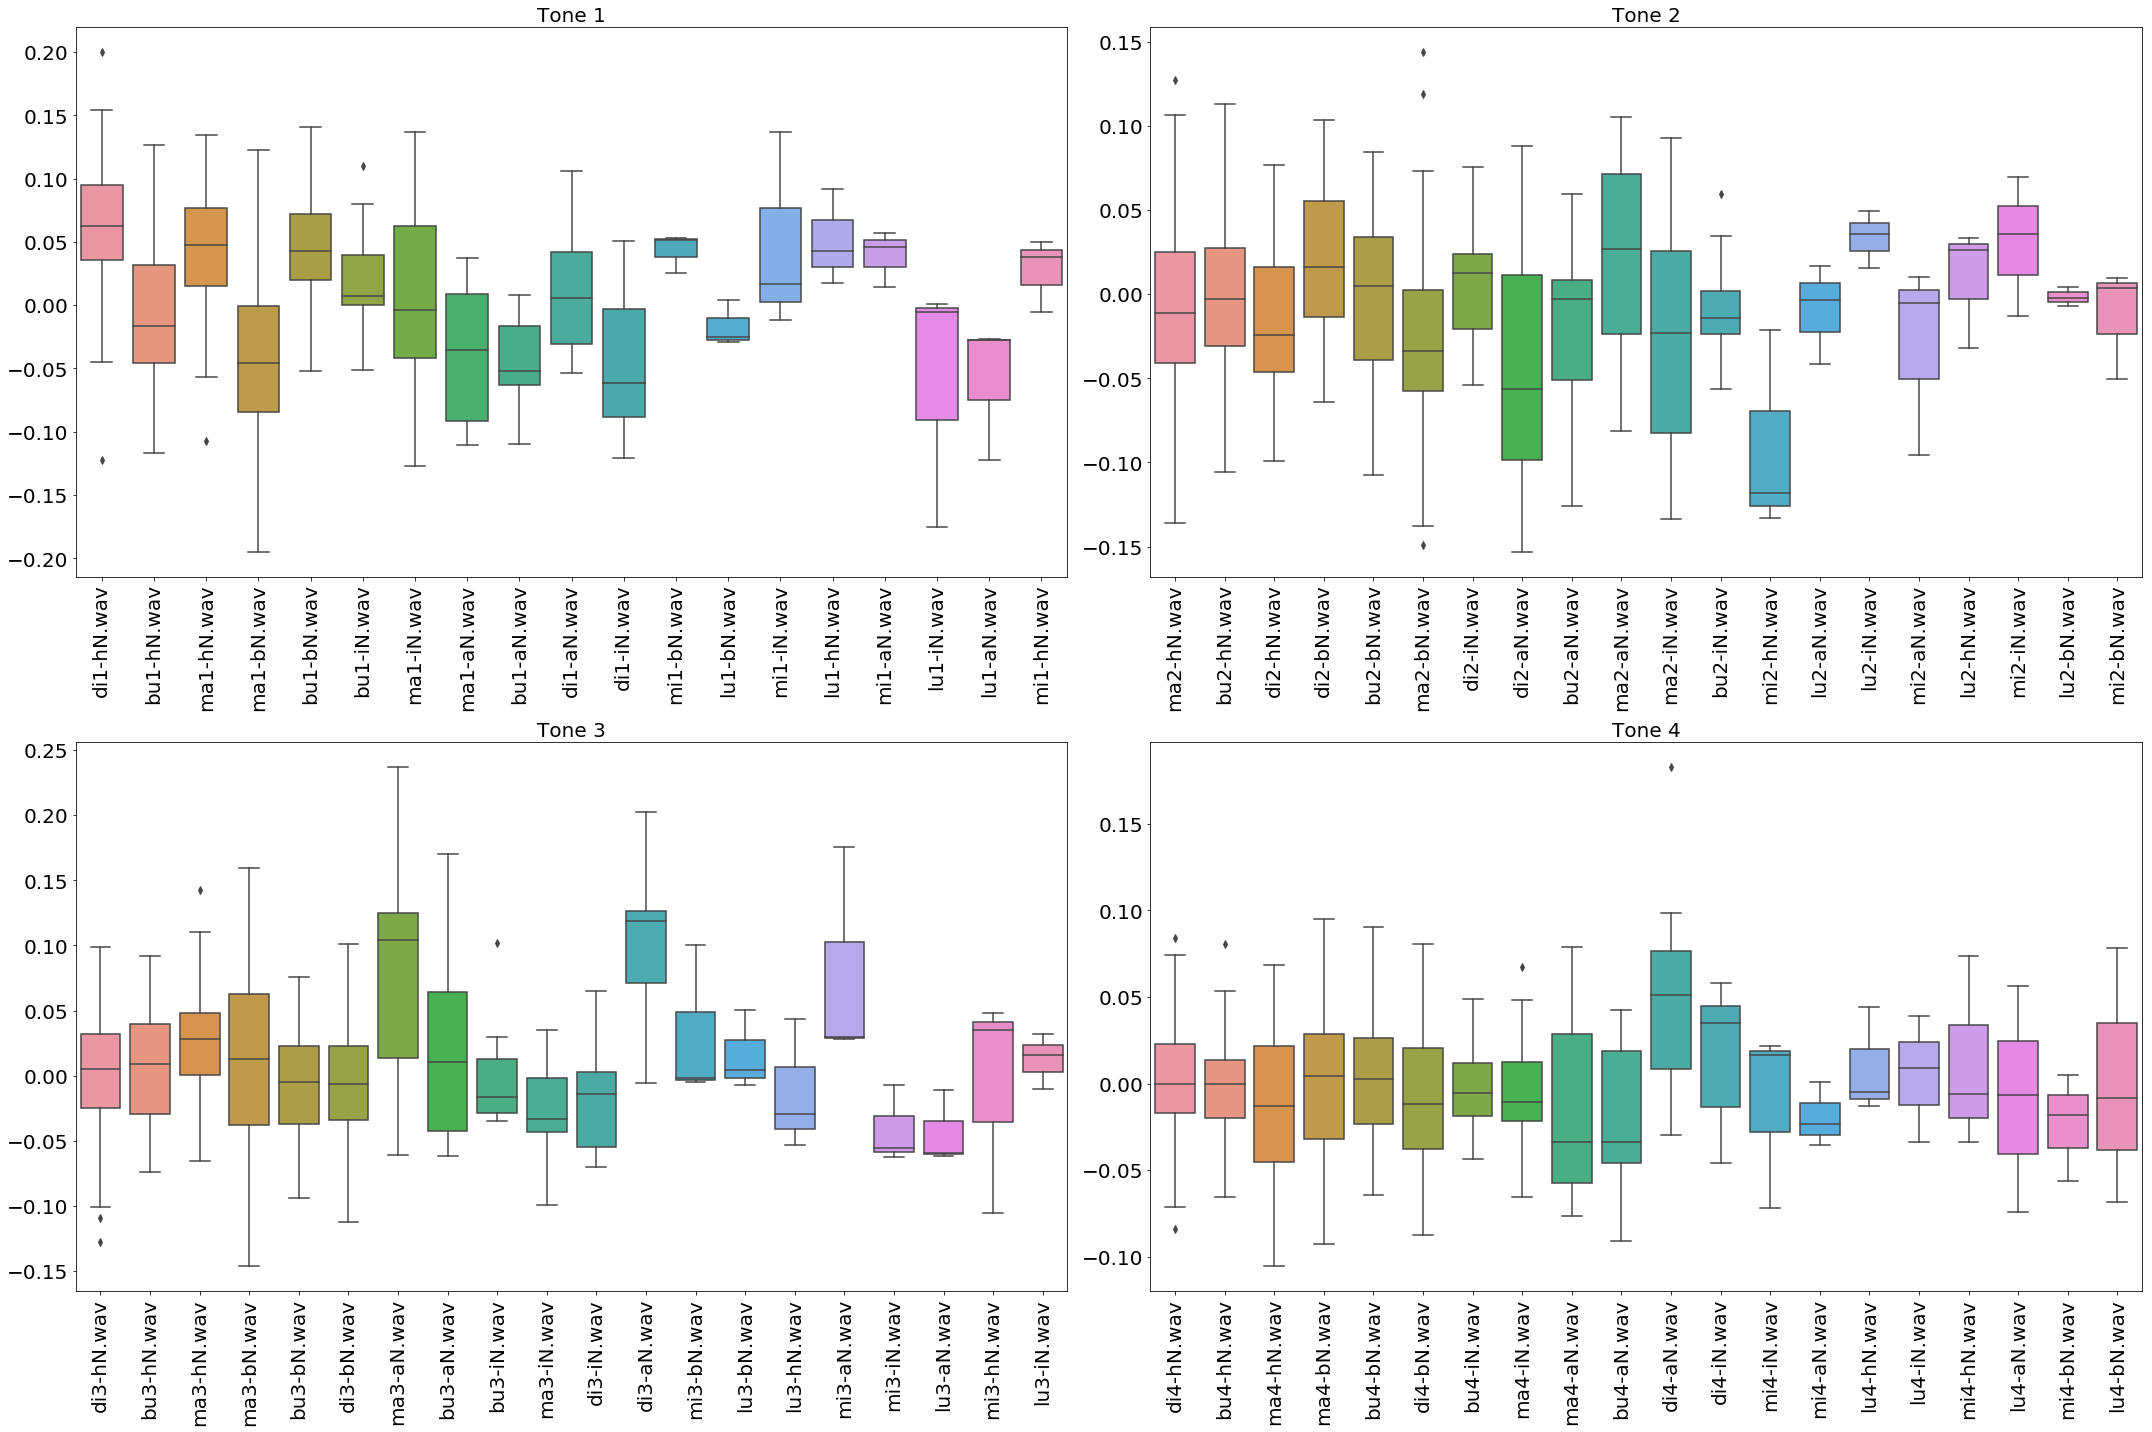

In [228]:
plt.figure(figsize = (30,20))
dfs = [correlations1, correlations2, correlations3, correlations4]
iterplot = 1
tone = 1
for f in dfs:
    plt.subplot(2,2,iterplot)
    sns.boxplot(data = f)
    plt.xticks(rotation=90, size = 20)
    plt.yticks(size = 20)
    plt.title('Tone ' + str(tone), size = 20)
    tone += 1
    iterplot += 1
plt.tight_layout()
plt.show()

    

#### Go through all elecs and run cross correlation, and get a averaged cross correlation value for each tone

In [353]:
all_cors = pd.DataFrame()
all_cors['elec'] = np.zeros(256)
all_cors['Tone 1'] = np.zeros(256)
all_cors['Tone 2'] = np.zeros(256)
all_cors['Tone 3'] = np.zeros(256)
all_cors['Tone 4'] = np.zeros(256)

for e in range(256):
    dataFFR = get_FFR(e,40)
    correlations = get_crosscorr_all(dataFFR)
    correlations2 = pd.DataFrame()
    correlations1 = pd.DataFrame()
    correlations3 = pd.DataFrame()
    correlations4 = pd.DataFrame()
    for c in correlations:
        if '2' in c:
            correlations2[c] = correlations[c]
        if '1' in c:
            correlations1[c] = correlations[c]
        if '3' in c:
            correlations3[c] = correlations[c]
        if '4' in c:
            correlations4[c] = correlations[c]

    
    ## find max correlation and append to list
    data_max1 = correlations1.median()
    data_max2 = correlations2.median()
    data_max3 = correlations3.median()
    data_max4 = correlations4.median()
    
    ## find average correlations and append to dataframe
    avg2 = sum(data_max2)/len(data_max2)
    avg1 = sum(data_max1)/len(data_max1)
    avg3 = sum(data_max3)/len(data_max3)
    avg4 = sum(data_max4)/len(data_max4)
    all_cors['elec'][e] = e
    all_cors['Tone 1'][e] = avg1
    all_cors['Tone 2'][e] = avg2
    all_cors['Tone 3'][e] = avg3
    all_cors['Tone 4'][e] = avg4






In [354]:
## break down to sig elecs plus 119
all_cors_sig = pd.DataFrame()
s1 = []
s2 = []
s3 = []
s4 = []

for i in range(256):
    if all_cors['elec'][i] in sig:
        s1.append(all_cors['Tone 1'][i])
        s2.append(all_cors['Tone 2'][i])
        s3.append(all_cors['Tone 3'][i])
        s4.append(all_cors['Tone 4'][i])

all_cors_sig['elecs'] = sig
all_cors_sig['Tone 1'] = s1
all_cors_sig['Tone 2'] = s2
all_cors_sig['Tone 3'] = s3
all_cors_sig['Tone 4'] = s4

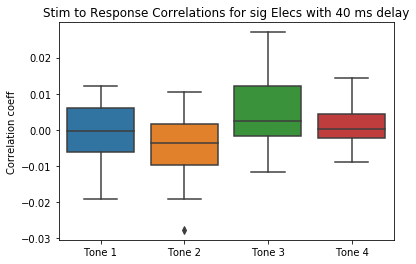

In [355]:
sns.boxplot(data = all_cors_sig[['Tone 1','Tone 2', 'Tone 3', 'Tone 4']])
plt.ylabel("Correlation coeff")
plt.title("Stim to Response Correlations for sig Elecs with 40 ms delay")
plt.show()

In [157]:
all_cors_sig.to_csv('correlations_sig_elecs.csv')

In [478]:
len(interesting_stims16)

6

In [33]:
plt.figure(figsize = (30,20))


x = 1
for i in interesting_stims:
    plt.subplot(4,2,x)
    myhg = dataStim[i]
    f,t, Sxx = signal.spectrogram(myhg, 1000, noverlap = 76, nperseg =90)
    plt.pcolormesh(t,f,Sxx, vmax = np.percentile(Sxx.flatten(), 99.9))
    x += 1

plt.show()

plt.figure(figsize = (30,20))


x = 1
for i in interesting_stims16:
    plt.subplot(3,2,x)
    myhg = dataStim[i]
    f,t, Sxx = signal.spectrogram(myhg, 1000, noverlap = 76, nperseg =90)
    plt.pcolormesh(t,f,Sxx, vmax = np.percentile(Sxx.flatten(), 99.9))
    x += 1

plt.show()

NameError: name 'interesting_stims' is not defined